In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy import signal
from tqdm import tqdm
from scipy import fftpack
from numpy.fft import *
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
def set_manual_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

seed = 150
set_manual_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def plot_graph(data, id):
    
    columns = data.columns
    length = data.shape[1] #Number of feature 
    
    plt_index = 0
    plt_column = 0
    
    fig, axes = plt.subplots(nrows=int(length/3),ncols=3, figsize=(15,int(length)))
    
    for i in range (2, length):
        
        datum = data[data['id'] == id]
    
        axes[plt_index, plt_column].set_title(columns[i])
        axes[plt_index, plt_column].plot(datum[str(columns[i])], lw=1.5, label = columns[i])
        
        plt_column += 1
        
        if plt_column == 3:
            plt_column = 0
            plt_index += 1

In [ ]:
DATA_PATH = '/content/drive/MyDrive/캐글/AI해커톤/'
OUTPUT_PATH = '/content/drive/MyDrive/캐글/AI해커톤/'

In [ ]:
def train_loader(path):
    train_x = pd.read_csv(path + 'train_features.csv')
    train_y = pd.read_csv(path + 'train_labels.csv')
    
    return train_x, train_y


def test_loader(path):
    test_x = pd.read_csv(path + 'test_features.csv')
    
    return test_x

In [ ]:
train, train_labels = train_loader(DATA_PATH)
test = test_loader(DATA_PATH)
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


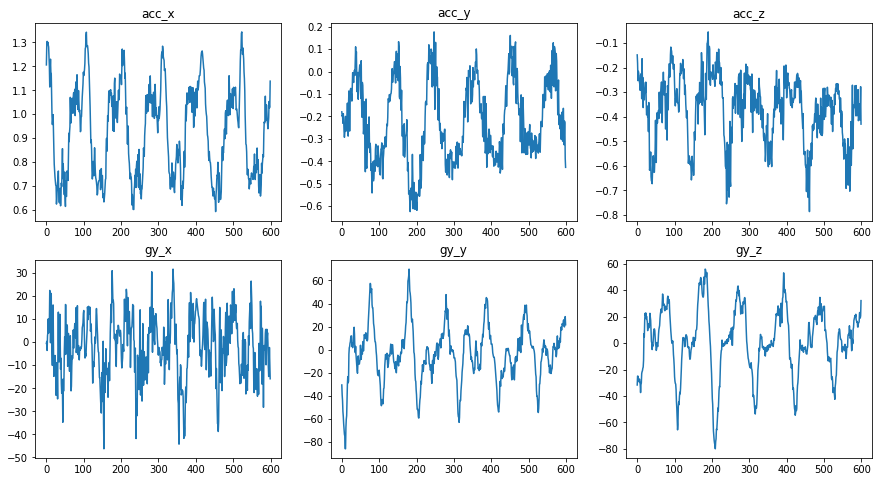

In [ ]:
plot_graph(train, id = 0)

In [ ]:
!pip install transforms3d

     |████████████████████████████████| 62 kB 1.1 MB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-py3-none-any.whl size=59373 sha256=f739e1e3ca3eb034e6309a28bd9d072b812fae98069f75213ba8825cc391df14
  Stored in directory: /root/.cache/pip/wheels/b5/b7/93/8985551f83720ce37548a5b543c75380bb707955a9c2c5d28c
Successfully built transforms3d


In [ ]:
import scipy
from transforms3d.axangles import axangle2mat

def permutation(data, nPerm=4, mSL=10):
    data_new = np.zeros(data.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile == True:
        segs = np.zeros(nPerm+1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(mSL, data.shape[0]-mSL, nPerm-1))
        segs[-1] = data.shape[0]
        if np.min(segs[1:]-segs[0:-1]) > mSL:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        data_temp = data[segs[idx[ii]]:segs[idx[ii]+1],:]
        data_new[pp:pp+len(data_temp),:] = data_temp
        pp += len(data_temp)
    return(data_new)

In [ ]:
def add_permutation(train, train_labels):
    
    train_acc, train_gy = train.iloc[:, 2:5], train.iloc[:, 5:]
    num=int(len(train_acc)/600)
                    
    train_columns = list(train.columns)
    acc_columns = train_columns[2:5]
    gy_columns = train_columns[5:]
    

    for i in tqdm(range(num)): #permutation을 이용한 data aug
        i *= 600
        acc_permu_data = pd.DataFrame(permutation(np.array(train_acc[i:i+600])), columns=acc_columns)
        train_acc = pd.concat([train_acc, acc_permu_data])
                    
    for i in tqdm(range(num)): #permutation을 이용한 data aug
        i *= 600
        gy_permu_data = pd.DataFrame(permutation(np.array(train_gy[i:i+600])), columns=gy_columns)
        train_gy = pd.concat([train_gy, gy_permu_data])       
    
    train = pd.concat([train_acc,train_gy],axis=1)
    train = train.reset_index()
    train = train.drop(['index'],axis=1)
                    
    idx = [] #id column 다시 생성
    time = []

    for i in tqdm(range(int(len(train)/600))):
        for j in range(600):
            idx.append(i)
            time.append(j)
                    
    train['id'] = idx
    train['time'] = time
                    
    train_labels = pd.concat([train_labels,train_labels])
    train = train[train_columns]
                    
    return train, train_labels   

In [ ]:
train_x, labels = add_permutation(train, train_labels)
train_x

100%|██████████| 6250/6250 [00:00<00:00, 8923.57it/s]


,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
3749995,6249,595,-0.068602,-0.930318,0.442937,-17.869606,-92.325355,-71.856090
3749996,6249,596,-0.068461,-0.952761,0.413800,-19.612632,-90.370510,-69.550051
3749997,6249,597,-0.145469,-0.912737,0.440656,-23.394058,-86.760972,-67.874487
3749998,6249,598,-0.215314,-0.865872,0.452528,-28.201192,-82.150995,-65.803943


In [ ]:
print(test.shape)
print(train.shape)

(469200, 8)
(1875000, 8)


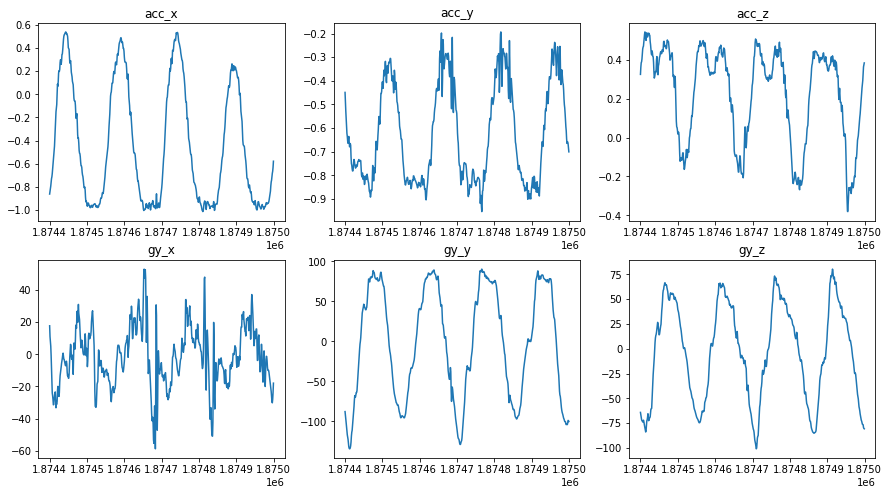

In [ ]:
plot_graph(train_x, id = 3124)

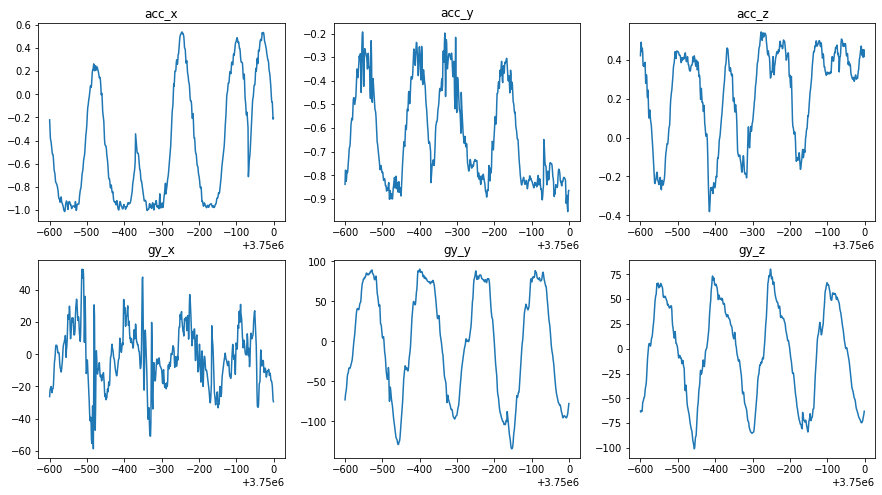

In [ ]:
plot_graph(train_x, id = 6249)

In [ ]:
def add_feature(data):
    data['acc_Energy']=(data['acc_x']**2+data['acc_y']**2+data['acc_z']**2)**(1/3)
    data['gy_Energy']=(data['gy_x']**2+data['gy_y']**2+data['gy_z']**2)**(1/3)
    data['gy_acc_Energy']=((data['gy_x']-data['acc_x'])**2+(data['gy_y']-data['acc_y'])**2+(data['gy_z']-data['acc_z'])**2)**(1/3)
    data['acc_roll'] = np.arctan2(data['acc_y'],np.sqrt(data['acc_x']**2+data['acc_z']**2))
    data['acc_pitch'] = np.arctan2(data['acc_x'],np.sqrt(data['acc_y']**2+data['acc_z']**2))
    
    return data

In [ ]:
train = add_feature(train_x)
test = add_feature(test)
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_roll,acc_pitch
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.146962,12.465436,12.427938,-0.146550,1.380095
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,1.200703,12.913284,12.865692,-0.151814,1.364146
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,1.217403,13.725729,13.692643,-0.145773,1.330405
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,1.209981,15.374021,15.314907,-0.173958,1.331665
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,1.211254,16.074363,16.017964,-0.141316,1.350615
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3749995,6249,595,-0.068602,-0.930318,0.442937,-17.869606,-92.325355,-71.856090,1.021658,24.105205,24.042216,-1.121822,-0.066481
3749996,6249,596,-0.068461,-0.952761,0.413800,-19.612632,-90.370510,-69.550051,1.027147,23.745395,23.676474,-1.156105,-0.065812
3749997,6249,597,-0.145469,-0.912737,0.440656,-23.394058,-86.760972,-67.874487,1.015888,23.319850,23.255732,-1.100442,-0.142552
3749998,6249,598,-0.215314,-0.865872,0.452528,-28.201192,-82.150995,-65.803943,1.000292,22.814034,22.753769,-1.046134,-0.216916


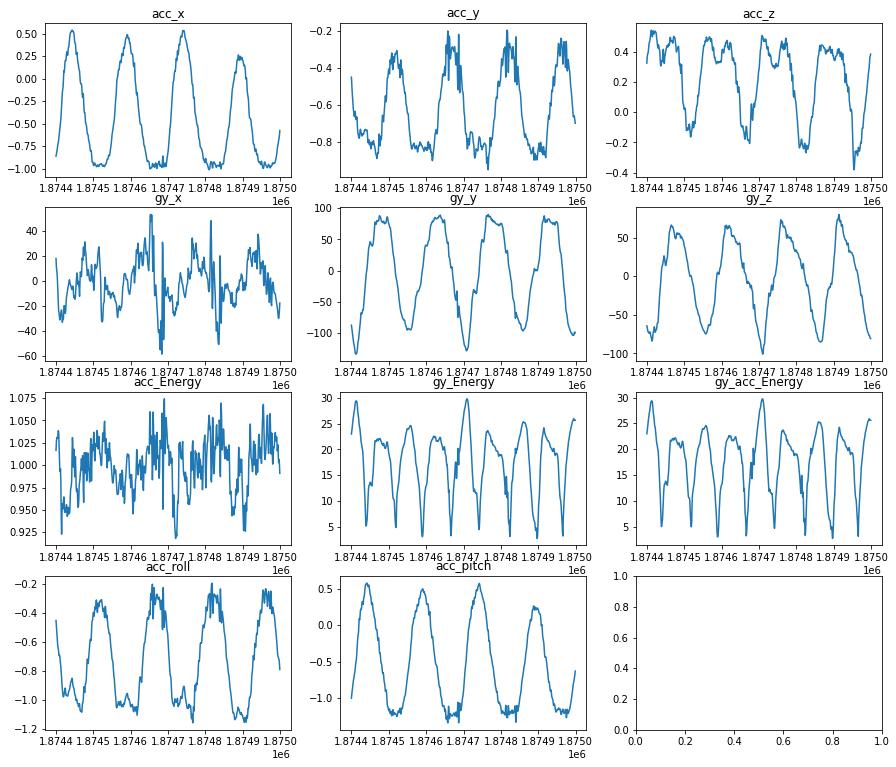

In [ ]:
plot_graph(train, id = 3124)

In [ ]:
def feature_diff(data):
    
    dt = 0.02
    data_diff = []
    feature_point = 11
    
    for i in tqdm(data['id'].unique()):
        movement = data.loc[data['id']==i]
        
        for feature in data.columns[2:feature_point]:
            signal = movement[feature].values            
            value = np.array([(signal[i+1]-signal[i])/dt for i in range(len(signal)-1)])
            value = np.insert(value,0,0)
            movement.loc[:, feature + '_dt'] = value
        data_diff.append(movement)
        
    data = pd.concat(data_diff)
    
    return data 

In [ ]:
train = feature_diff(train)
test = feature_diff(test)

100%|██████████| 782/782 [00:13<00:00, 57.73it/s]


In [ ]:
print(test.shape)
print(train.shape)

(469200, 22)
(3750000, 22)


In [ ]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_roll,acc_pitch,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.146962,12.465436,12.427938,-0.146550,1.380095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,1.200703,12.913284,12.865692,-0.151814,1.364146,4.080495,-0.980114,-1.699854,44.735403,-429.504677,337.444793,2.687024,22.392358,21.887693
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,1.217403,13.725729,13.692643,-0.145773,1.330405,0.845632,0.192961,-3.546937,-196.018888,-249.173073,-4.620631,0.835012,40.622253,41.347563
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,1.209981,15.374021,15.314907,-0.173958,1.331665,-0.575711,-1.762585,1.908626,316.513181,-473.763910,-121.719195,-0.371100,82.414636,81.113199
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,1.211254,16.074363,16.017964,-0.141316,1.350615,0.389598,2.130453,-0.365665,78.686055,-215.435892,-25.361098,0.063656,35.017060,35.152822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3749995,6249,595,-0.068602,-0.930318,0.442937,-17.869606,-92.325355,-71.856090,1.021658,24.105205,24.042216,-1.121822,-0.066481,-0.931005,-2.304071,-0.427423,-63.980681,82.113946,79.508195,1.280144,-13.975390,-14.300496
3749996,6249,596,-0.068461,-0.952761,0.413800,-19.612632,-90.370510,-69.550051,1.027147,23.745395,23.676474,-1.156105,-0.065812,0.007087,-1.122172,-1.456872,-87.151267,97.742238,115.301952,0.274445,-17.990462,-18.287123
3749997,6249,597,-0.145469,-0.912737,0.440656,-23.394058,-86.760972,-67.874487,1.015888,23.319850,23.255732,-1.100442,-0.142552,-3.850439,2.001219,1.342800,-189.071309,180.476876,83.778192,-0.562903,-21.277249,-21.037107
3749998,6249,598,-0.215314,-0.865872,0.452528,-28.201192,-82.150995,-65.803943,1.000292,22.814034,22.753769,-1.046134,-0.216916,-3.492211,2.343239,0.593617,-240.356695,230.498841,103.527210,-0.779837,-25.290806,-25.098103


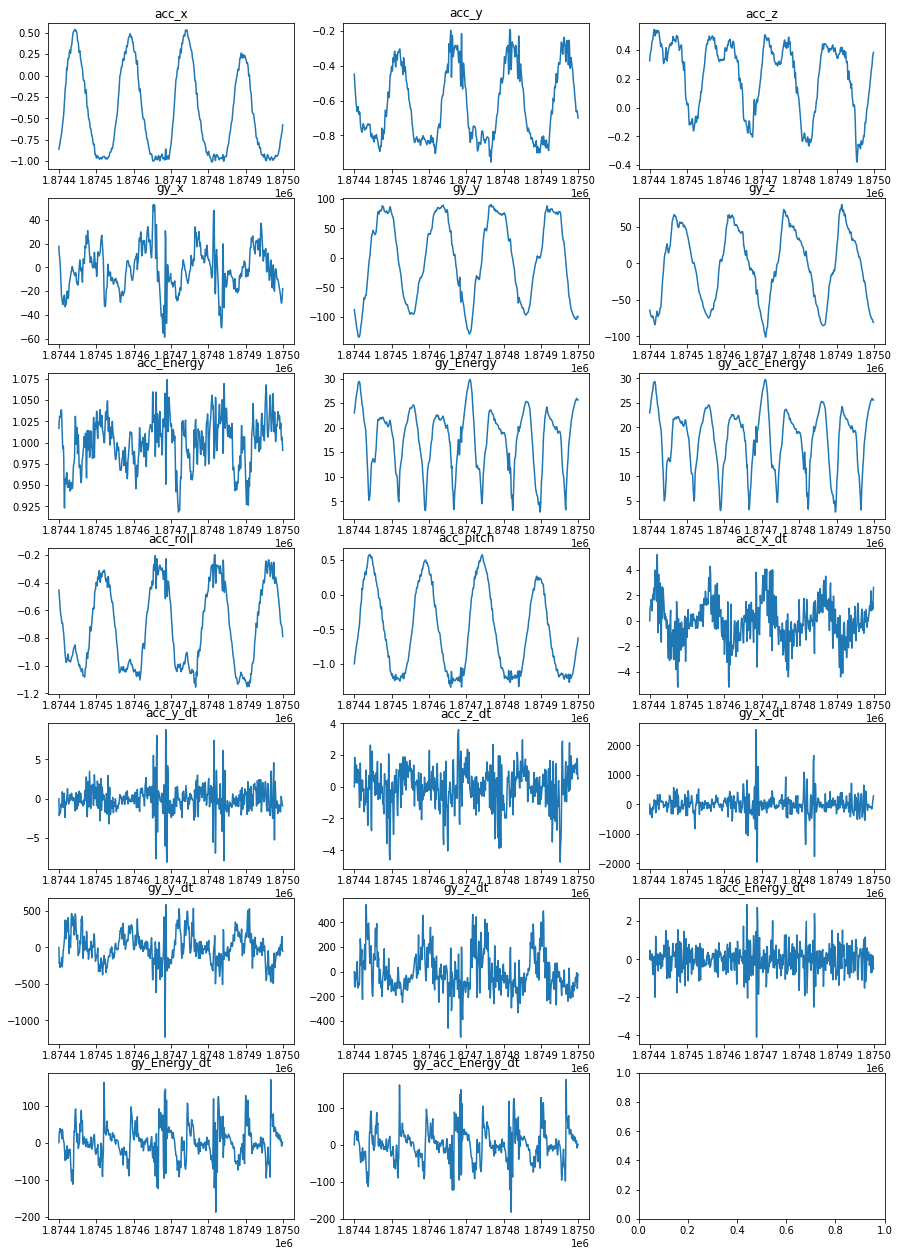

In [ ]:
plot_graph(train, id = 3124)

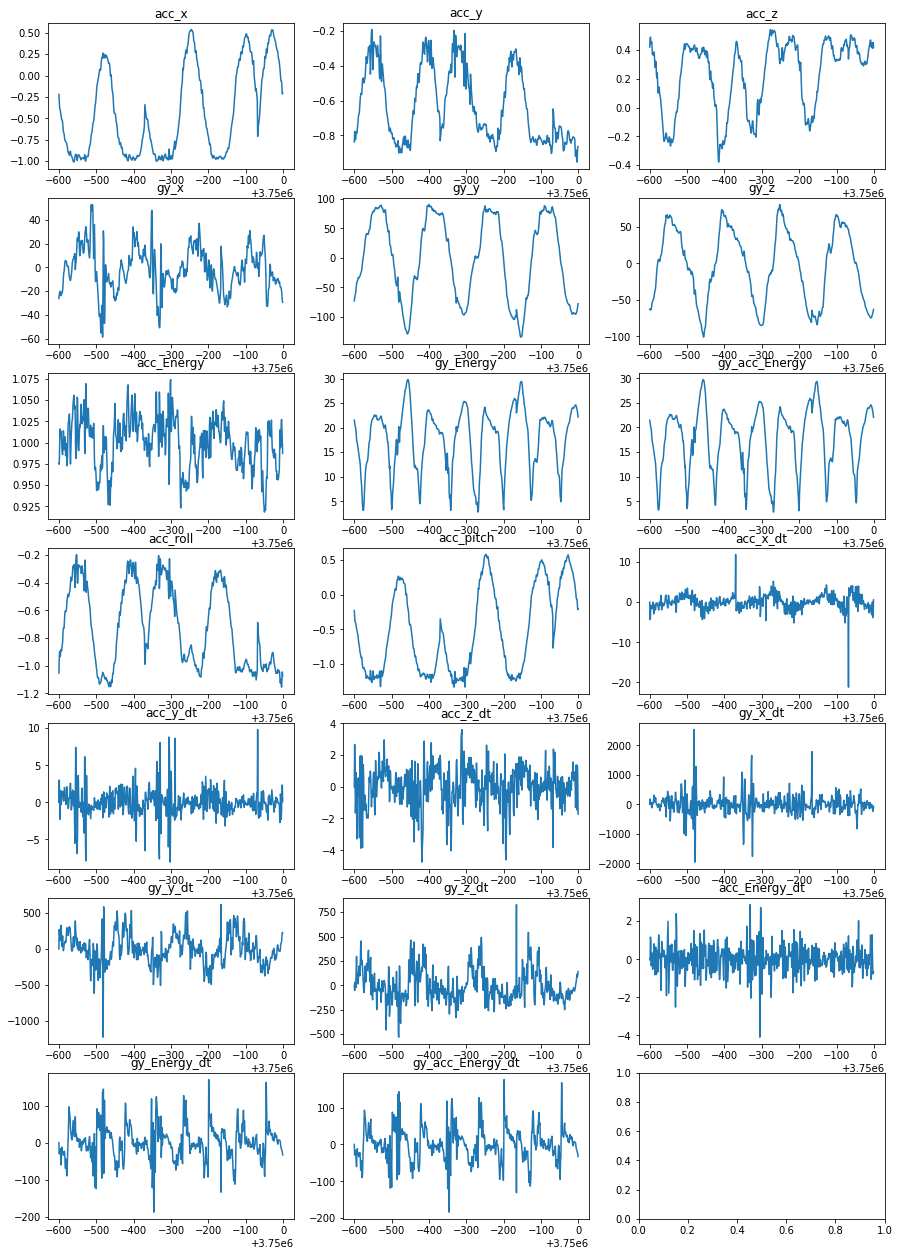

In [ ]:
plot_graph(train, id = 6249)

In [ ]:
def fourier_transform(signal):
    complex_f_signal= fftpack.fft(signal)
    amplitude_f_signal=np.abs(complex_f_signal)
    return amplitude_f_signal

In [ ]:
def feature_fourier(data):
    fft=[]
    for i in tqdm(data['id'].unique()):
        movement = data.loc[data['id']==i]
        for feature in data.columns[2:8]:
            movement[feature] = fourier_transform(movement[feature].values)
        fft.append(movement)
        
    data = pd.concat(fft)
    return data

In [ ]:
test

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_roll,acc_pitch,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,3125,0,-0.628100,-0.160155,0.151487,49.665357,88.435961,13.597668,0.762377,21.878437,21.938882,-0.242979,-1.233250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3125,1,-0.462548,0.012462,-0.053726,56.953059,96.185341,16.278458,0.600917,23.367908,23.399763,0.026755,-1.452121,8.277606,8.630860,-10.260605,364.385137,387.469010,134.039504,-8.072977,74.473561,73.044041
2,3125,2,-0.363481,-0.091789,-0.130004,29.557396,93.836453,13.329043,0.539978,21.440856,21.471510,-0.233441,-1.158111,4.953330,-5.212527,-3.813919,-1369.783175,-117.444408,-147.470749,-3.046963,-96.352572,-96.412634
3,3125,3,-0.351750,-0.239870,-0.193053,23.686172,88.608721,13.449771,0.602338,20.482783,20.533967,-0.538810,-0.851763,0.586560,-7.404041,-3.152460,-293.561181,-261.386607,6.036401,3.118006,-47.903682,-46.877152
4,3125,4,-0.312934,-0.123762,-0.318621,20.410071,85.327707,13.884912,0.598853,19.908061,19.944125,-0.270340,-0.741318,1.940804,5.805371,-6.278395,-163.805080,-164.050703,21.757050,-0.174231,-28.736096,-29.492133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469195,3906,595,0.104191,-0.784979,0.639513,-10.475346,14.095361,-190.358982,1.011867,33.185050,33.266220,-0.880740,0.102543,-3.361947,3.580749,0.006738,-771.499131,-849.527466,-8.671145,-2.122263,-9.277974,-9.636798
469196,3906,596,0.103297,-0.758954,0.615687,-25.360272,-8.523018,-180.393291,0.988451,32.158563,32.227841,-0.882444,0.105307,-0.044724,1.301266,-1.191327,-744.246300,-1130.918984,498.284561,-1.170808,-51.324317,-51.918937
469197,3906,597,0.128294,-0.749389,0.586184,-27.917723,-23.186245,-162.624160,0.973171,30.280197,30.339698,-0.895610,0.134037,1.249868,0.478247,-1.475149,-127.872573,-733.161359,888.456533,-0.763970,-93.918343,-94.407192
469198,3906,598,0.104130,-0.692731,0.573397,-27.847980,-30.407555,-138.761676,0.935801,27.569491,27.623600,-0.871391,0.115283,-1.208173,2.832870,-0.639335,3.487160,-361.065463,1193.124196,-1.868499,-135.535264,-135.804895


In [ ]:
train = feature_fourier(train)
test = feature_fourier(test)

100%|██████████| 782/782 [00:02<00:00, 328.00it/s]


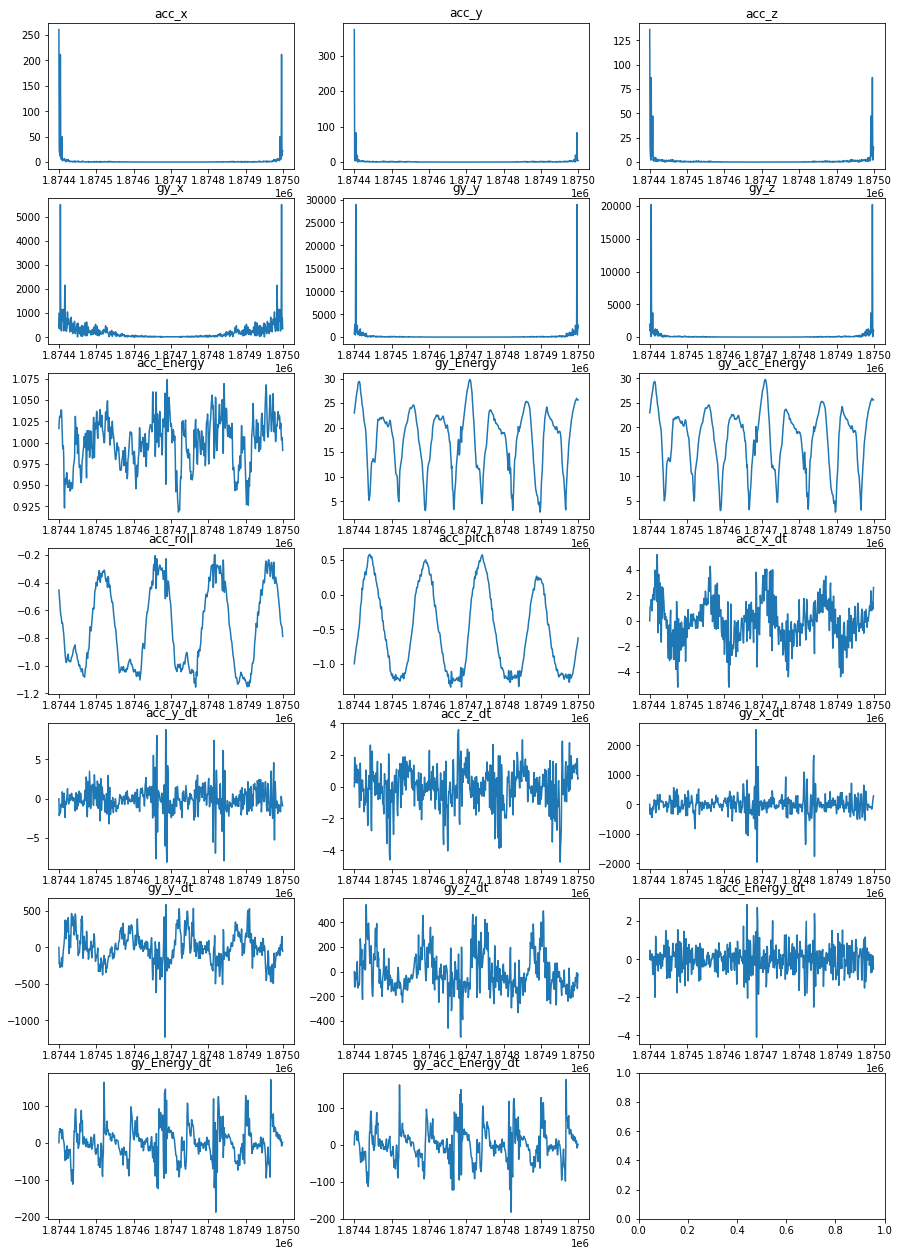

In [ ]:
plot_graph(train, id = 3124)

In [ ]:
test

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_Energy,gy_Energy,gy_acc_Energy,acc_roll,acc_pitch,acc_x_dt,acc_y_dt,acc_z_dt,gy_x_dt,gy_y_dt,gy_z_dt,acc_Energy_dt,gy_Energy_dt,gy_acc_Energy_dt
0,3125,0,611.238360,11.744605,139.355669,1911.076959,1639.123438,1200.410049,0.762377,21.878437,21.938882,-0.242979,-1.233250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3125,1,0.239141,5.023774,12.965295,246.184956,177.957484,183.601086,0.600917,23.367908,23.399763,0.026755,-1.452121,8.277606,8.630860,-10.260605,364.385137,387.469010,134.039504,-8.072977,74.473561,73.044041
2,3125,2,1.180566,0.679387,3.327975,148.188325,515.530754,67.280691,0.539978,21.440856,21.471510,-0.233441,-1.158111,4.953330,-5.212527,-3.813919,-1369.783175,-117.444408,-147.470749,-3.046963,-96.352572,-96.412634
3,3125,3,2.795580,4.075080,1.470555,483.821952,370.138319,434.696668,0.602338,20.482783,20.533967,-0.538810,-0.851763,0.586560,-7.404041,-3.152460,-293.561181,-261.386607,6.036401,3.118006,-47.903682,-46.877152
4,3125,4,5.481271,2.115022,1.977427,434.086739,684.323105,318.399242,0.598853,19.908061,19.944125,-0.270340,-0.741318,1.940804,5.805371,-6.278395,-163.805080,-164.050703,21.757050,-0.174231,-28.736096,-29.492133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469195,3906,595,2.747623,15.849474,5.802464,3685.782139,2260.729010,3329.375581,1.011867,33.185050,33.266220,-0.880740,0.102543,-3.361947,3.580749,0.006738,-771.499131,-849.527466,-8.671145,-2.122263,-9.277974,-9.636798
469196,3906,596,28.270550,39.565052,20.036836,6694.121592,4055.317339,2046.205123,0.988451,32.158563,32.227841,-0.882444,0.105307,-0.044724,1.301266,-1.191327,-744.246300,-1130.918984,498.284561,-1.170808,-51.324317,-51.918937
469197,3906,597,56.862439,44.152073,50.172734,13133.830784,6823.498741,1247.228760,0.973171,30.280197,30.339698,-0.895610,0.134037,1.249868,0.478247,-1.475149,-127.872573,-733.161359,888.456533,-0.763970,-93.918343,-94.407192
469198,3906,598,65.731720,37.380610,105.157482,2366.726592,8014.470685,2034.956842,0.935801,27.569491,27.623600,-0.871391,0.115283,-1.208173,2.832870,-0.639335,3.487160,-361.065463,1193.124196,-1.868499,-135.535264,-135.804895


In [ ]:
col = train.columns
train_s = train.copy()
test_s = test.copy()

In [ ]:
scaler = StandardScaler()

train_s.iloc[:,2:]= scaler.fit_transform(train.iloc[:,2:])

test_s.iloc[:,2:]= scaler.transform(test.iloc[:,2:])

In [ ]:
X_train = np.array(train_s.iloc[:,2:]).reshape(6250, 600, -1)
X_test=np.array(test_s.iloc[:,2:]).reshape(782, 600, -1)
train_labels_ohe = pd.get_dummies(labels['label'])
Y_train = train_labels_ohe.values

In [ ]:
print(X_test.shape)
print(X_train.shape)
print(Y_train.shape)

(782, 600, 20)
(6250, 600, 20)
(6250, 61)


In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras import backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.model_selection import KFold,StratifiedKFold
from numpy.random import seed

In [ ]:
def cnn_model(input_shape, classes):
    
    input_layer = keras.layers.Input(input_shape)
    conv1 = keras.layers.Conv1D(filters=128, kernel_size=9, padding='same')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)
    conv1 = keras.layers.Dropout(rate=0.3)(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=6, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)
    conv2 = keras.layers.Dropout(rate=0.4)(conv2)
    
    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)
    conv3 = keras.layers.Dropout(rate=0.5)(conv3)
    
    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    
    output_layer = keras.layers.Dense(classes, activation='softmax')(gap)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(loss='categorical_crossentropy', optimizer = tf.optimizers.Adam(), 
        metrics=['accuracy'])
    
    return model

In [ ]:
def gru_model(input_shape, classes):
    
    input_layer = keras.layers.Input(input_shape)
    gru1 = keras.layers.GRU(256, return_sequences = True, dropout = 0.2)(input_layer)
    ap = keras.layers.AveragePooling1D()(gru1)
    gru2 = keras.layers.GRU(150, return_sequences = True, dropout = 0.2)(ap)
    gap = keras.layers.GlobalAveragePooling1D()(gru2)
    output_layer = keras.layers.Dense(classes, activation = "softmax")(gap)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(loss='categorical_crossentropy', optimizer = tf.optimizers.Adam(), 
        metrics=['accuracy'])
    
    return model

In [ ]:
def training_evaluation(model_, seed):
    
    accuracy = []
    losss=[]
    models=[]
    preds = []
    
    skf = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True)
    reLR = ReduceLROnPlateau(patience = 4,verbose = 1,factor = 0.5) 
    es =EarlyStopping(monitor='val_loss', patience=8, mode='min')
    
    for i, (train, validation) in enumerate(skf.split(X_train, Y_train.argmax(1))) :
        mc = ModelCheckpoint(OUTPUT_PATH + f'Model_2nd_aug_rot_{i + 1}.h5',save_best_only=True, verbose=0, monitor = 'val_loss', mode = 'min', save_weights_only=True)
        print("-" * 20 +"Fold_"+str(i+1)+ "-" * 20)
        with tf.device('/device:GPU:0'):
          model = model_
          history = model.fit(X_train[train], Y_train[train], epochs = 100, validation_data= (X_train[validation], Y_train[validation]), 
                              verbose=1,batch_size=64,callbacks=[es,mc,reLR])
          model.load_weights(OUTPUT_PATH + f'Model_2nd_aug_rot_{i + 1}.h5')

        k_accuracy = '%.4f' % (model.evaluate(X_train[validation], Y_train[validation])[1])
        k_loss = '%.4f' % (model.evaluate(X_train[validation], Y_train[validation])[0])

        accuracy.append(k_accuracy)
        losss.append(k_loss)
        models.append(model)
        
    print('\nK-fold cross validation Auc: {}'.format(accuracy))
    print('\nK-fold cross validation loss: {}'.format(losss))
    
   
    for model in models:
        pred = model.predict(X_test)
        preds.append(pred)
        
    pred = np.mean(preds, axis=0)
    return pred

In [ ]:
seed = 2021
model1 = cnn_model((600, 20),61)

pred1 = training_evaluation(model1, seed)

In [ ]:
seed = 2021
model2 = gru_model((600, 20),61)

pred2 = training_evaluation(model2, seed)

--------------------Fold_1--------------------
Epoch 1/100
66/66 [==============================] - 20s 246ms/step - loss: 2.4347 - accuracy: 0.5072 - val_loss: 1.8070 - val_accuracy: 0.5585
Epoch 2/100
66/66 [==============================] - 15s 231ms/step - loss: 1.6134 - accuracy: 0.5989 - val_loss: 1.4835 - val_accuracy: 0.6435
Epoch 3/100
66/66 [==============================] - 15s 230ms/step - loss: 1.3461 - accuracy: 0.6464 - val_loss: 1.2397 - val_accuracy: 0.6766
Epoch 4/100
66/66 [==============================] - 15s 230ms/step - loss: 1.1576 - accuracy: 0.6923 - val_loss: 1.1023 - val_accuracy: 0.7001
Epoch 5/100
66/66 [==============================] - 15s 231ms/step - loss: 1.0247 - accuracy: 0.7216 - val_loss: 0.9921 - val_accuracy: 0.7332
Epoch 6/100
66/66 [==============================] - 15s 230ms/step - loss: 0.9204 - accuracy: 0.7516 - val_loss: 0.9292 - val_accuracy: 0.7380
Epoch 7/100
66/66 [==============================] - 15s 231ms/step - loss: 0.8413 - accu

In [ ]:
seed = 200
model2 = gru_model((600, 20),61)

pred3 = training_evaluation(model2, seed)

In [ ]:
pred1

array([[5.30318459e-07, 2.92309044e-09, 1.99548475e-10, ...,
        8.84313195e-04, 4.70350336e-09, 4.64035388e-08],
       [1.25135790e-04, 1.02503543e-06, 1.01094690e-06, ...,
        2.72001728e-08, 6.19605044e-06, 4.21279111e-07],
       [4.59927280e-04, 3.57405782e-01, 9.52113766e-09, ...,
        2.80757746e-07, 2.64446926e-03, 1.12064961e-04],
       ...,
       [4.16283117e-04, 1.14345717e-07, 3.93439365e-07, ...,
        2.60187085e-06, 4.05624320e-07, 4.73332366e-05],
       [1.67671703e-06, 1.60745607e-04, 4.37249696e-07, ...,
        4.29313580e-08, 6.01521519e-04, 7.82517304e-08],
       [1.45025069e-05, 4.56710403e-08, 1.45788634e-08, ...,
        2.01457260e-05, 9.06918203e-08, 8.52952871e-06]], dtype=float32)

In [ ]:
pred2

array([[2.3084301e-04, 3.0095612e-07, 4.4997712e-05, ..., 1.3631952e-02,
        6.2059867e-06, 3.8294138e-03],
       [1.0827832e-04, 1.0602256e-07, 3.7986666e-08, ..., 1.2076069e-08,
        1.2041518e-07, 1.1840911e-05],
       [2.7233807e-03, 7.2670108e-01, 1.1786582e-06, ..., 7.6429551e-06,
        6.4002228e-04, 4.4469908e-04],
       ...,
       [4.8433142e-04, 2.7618091e-08, 3.8331913e-07, ..., 7.1762889e-07,
        9.6820374e-09, 3.7727287e-04],
       [3.1019583e-06, 7.5957744e-04, 1.9305592e-06, ..., 8.8899263e-08,
        1.2834915e-03, 5.3453977e-07],
       [4.9296871e-04, 6.6644226e-08, 1.7563640e-07, ..., 5.2115756e-06,
        1.3127490e-07, 2.6766636e-04]], dtype=float32)

In [ ]:
pred = (pred1/2) + (pred2/2) 

In [ ]:
submission=pd.read_csv(DATA_PATH+'sample_submission.csv')
submission.iloc[:,1:]=pred
submission.to_csv('cnn_gru150.csv',index=False)
submission

In [ ]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.000116,1.519396e-07,2.249896e-05,0.000002,4.310786e-04,1.363541e-06,3.583069e-06,3.788318e-07,0.000046,3.473364e-04,4.649135e-02,3.477253e-01,5.259551e-04,5.392896e-01,5.579199e-03,1.021555e-04,1.033046e-05,6.713571e-07,3.492083e-05,1.274962e-05,8.971928e-06,4.025803e-06,5.052322e-05,1.238947e-03,4.396021e-02,1.653652e-06,1.330224e-05,1.058054e-07,9.519255e-05,3.631048e-06,2.492391e-04,2.779080e-04,0.000031,0.000004,1.448498e-04,4.011316e-06,5.585219e-04,1.518063e-06,0.000063,1.885709e-05,4.295023e-07,3.895690e-07,2.201729e-03,1.472890e-04,1.693018e-05,3.714022e-06,2.511037e-04,5.843811e-07,0.000283,0.000059,1.201945e-05,3.062308e-04,2.560778e-05,1.767382e-05,3.806434e-06,7.490381e-06,5.025551e-07,1.561266e-05,7.258133e-03,3.105345e-06,1.914730e-03
1,3126,0.000117,5.655290e-07,5.244668e-07,0.001918,1.305993e-06,4.187479e-04,1.153030e-08,1.869691e-06,0.000001,1.858864e-06,1.595149e-07,3.167140e-07,9.361123e-09,3.103752e-09,8.690838e-09,2.365123e-04,5.562428e-07,2.906175e-06,1.495939e-05,5.946866e-08,2.612213e-06,9.597601e-05,5.435349e-04,1.303716e-05,2.888168e-07,8.614422e-05,9.956713e-01,1.274356e-05,4.297864e-08,9.039890e-08,2.454707e-06,1.376789e-07,0.000036,0.000020,1.285454e-06,6.792057e-05,6.263537e-06,1.872803e-08,0.000002,2.877838e-09,4.783506e-04,7.206134e-06,4.944838e-07,5.270201e-07,5.296646e-08,9.777809e-07,2.373733e-07,1.093932e-05,0.000015,0.000109,5.981533e-05,1.813068e-07,1.492352e-08,2.241708e-06,1.337249e-06,1.781248e-05,4.527683e-07,8.572717e-06,1.963812e-08,3.158233e-06,6.131095e-06
2,3127,0.001592,5.420535e-01,5.940897e-07,0.000009,2.140159e-06,5.864942e-05,5.829318e-03,2.276763e-03,0.000451,1.687086e-05,3.975467e-05,5.571333e-05,1.552675e-05,5.861889e-06,6.980677e-05,2.632704e-05,7.581741e-04,2.214984e-04,3.858221e-06,2.238812e-06,1.844981e-05,3.593379e-05,1.895923e-06,3.622134e-06,8.570633e-06,5.135325e-05,9.679558e-04,8.553475e-05,2.221859e-03,3.057355e-04,1.367470e-07,1.172414e-06,0.000148,0.004393,3.834091e-05,6.702344e-06,7.493698e-03,1.482241e-03,0.000432,9.387143e-04,7.830828e-04,1.355771e-05,8.868855e-04,7.349874e-03,3.496869e-03,4.103593e-01,9.306378e-05,1.281836e-03,0.000411,0.000033,1.415216e-04,4.359310e-06,2.679108e-05,5.659664e-07,7.934496e-05,1.480174e-05,9.705332e-04,5.568188e-06,3.961856e-06,1.642246e-03,2.783820e-04
3,3128,0.000617,4.552404e-07,2.627365e-05,0.000013,9.839358e-08,2.500800e-06,9.808333e-08,1.818729e-05,0.000174,1.786649e-06,4.210878e-05,3.344295e-06,2.080315e-08,2.823501e-08,1.454370e-07,3.452036e-05,1.041880e-07,6.091991e-07,9.512507e-08,1.009647e-07,2.088560e-07,3.207062e-05,1.363948e-06,7.995657e-05,5.133732e-06,7.262447e-07,9.915694e-01,1.448682e-05,9.391006e-06,3.872212e-06,1.597885e-05,9.072803e-07,0.001367,0.000001,4.324912e-07,2.850667e-04,2.279692e-06,4.353808e-08,0.000015,1.444834e-07,3.577460e-07,8.310023e-06,4.038549e-06,2.082387e-05,8.343079e-07,3.045271e-06,1.399603e-07,1.276375e-05,0.000435,0.004561,2.249315e-04,1.944868e-06,1.100933e-07,4.761159e-07,2.867543e-06,5.254702e-06,1.702449e-07,3.093319e-06,2.231333e-07,1.899037e-07,3.747206e-04
4,3129,0.000465,1.312800e-07,5.604650e-08,0.000017,1.092616e-04,4.313875e-06,2.049600e-08,1.181990e-07,0.000014,5.646500e-06,7.515403e-07,1.242378e-06,2.562268e-08,5.618773e-09,1.182063e-07,9.995541e-05,8.296277e-07,2.859196e-07,2.304839e-05,5.695815e-08,1.348702e-07,1.002876e-06,3.680243e-05,3.075902e-07,1.565901e-05,2.355840e-06,9.969926e-01,1.055850e-08,1.829898e-07,1.243913e-07,4.600295e-06,4.835078e-07,0.000039,0.000008,4.324478e-05,1.258316e-06,8.673622e-07,2.126564e-09,0.000008,2.360772e-08,3.591326e-07,1.193406e-07,1.388092e-06,3.639254e-06,7.020918e-09,3.345382e-07,5.189294e-07,2.101120e-06,0.000238,0.000126,5.548075e-05,6.533723e-08,2.033698e-08,1.204047e-07,7.220643e-08,2.621823e-07,2.855616e-09,1.529530e-03,4.214250e-07,6.174276e

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/캐글/AI해커톤/cnn_gru4_150.csv')

In [ ]:
data

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.000001,1.520505e-07,4.198838e-06,1.009941e-06,5.093176e-05,1.179092e-06,5.685633e-07,1.202310e-06,1.922448e-06,6.580465e-05,3.025270e-02,2.138690e-01,1.197819e-04,7.332168e-01,1.855032e-03,1.797375e-05,1.192635e-06,4.447704e-07,1.262655e-06,2.468379e-05,8.958875e-06,2.025646e-06,3.185880e-05,1.710819e-03,1.155152e-02,1.487226e-07,8.279415e-06,1.095527e-07,8.335133e-06,1.647390e-06,6.494177e-05,7.869230e-05,0.000028,3.097173e-06,9.810738e-06,3.149125e-06,4.568834e-04,7.125460e-07,5.261175e-05,1.642840e-06,5.727104e-06,5.169427e-07,1.129616e-03,7.443004e-05,5.426863e-06,6.152113e-06,1.420560e-04,4.950172e-07,0.000014,0.000001,7.650062e-07,5.809925e-04,1.477918e-05,4.524655e-05,3.554270e-07,2.281633e-06,9.276344e-08,3.443167e-06,4.336137e-03,2.896832e-07,1.251015e-04
1,3126,0.000120,2.840083e-06,2.479883e-06,4.668332e-03,7.933089e-07,5.381782e-04,2.323808e-08,7.831816e-06,7.020239e-07,1.690377e-06,6.815956e-07,8.843547e-08,5.982211e-09,7.737239e-09,4.724698e-08,1.416633e-04,8.733406e-06,8.883729e-07,2.960236e-06,3.306632e-07,7.079505e-06,1.914071e-04,2.380004e-04,8.121027e-06,1.589611e-06,5.799191e-05,9.915222e-01,1.889393e-05,8.581702e-09,1.186476e-08,1.504692e-06,1.278203e-07,0.000058,5.087177e-05,9.114196e-06,1.669786e-05,2.263601e-05,4.359261e-07,8.183921e-08,7.287560e-10,2.060425e-03,1.955660e-05,5.735278e-07,2.368448e-07,2.337943e-07,4.216839e-06,1.064730e-07,2.647977e-05,0.000024,0.000031,3.162348e-05,4.232196e-07,4.346015e-09,5.740394e-06,8.854621e-06,3.523583e-05,9.596097e-07,2.613896e-05,1.210653e-07,4.542213e-06,1.639242e-05
2,3127,0.000407,1.329513e-01,6.994918e-07,4.250675e-06,1.704604e-05,9.599160e-05,4.504373e-04,1.139648e-03,2.606939e-04,9.001830e-06,1.764786e-05,1.692853e-06,6.906177e-06,2.528685e-06,7.254772e-04,3.078704e-04,4.200460e-04,3.843356e-04,1.010400e-05,1.169997e-06,1.269332e-05,3.972877e-05,1.008604e-06,1.251642e-06,3.291256e-06,4.626425e-06,2.869843e-04,7.652849e-05,4.592768e-04,1.925031e-03,9.423883e-07,3.888808e-07,0.000497,2.390591e-03,1.044789e-03,8.758012e-06,5.009858e-04,1.039086e-03,7.011948e-04,1.207620e-04,5.478281e-05,4.337563e-05,8.639161e-04,1.223467e-02,4.977817e-03,8.302507e-01,4.430159e-06,3.244790e-04,0.003039,0.000025,2.462353e-05,2.777358e-07,2.117536e-05,1.696872e-07,1.531749e-04,2.199650e-07,1.830755e-04,7.226354e-06,2.160734e-06,1.287323e-03,1.727629e-04
3,3128,0.000117,1.774897e-07,6.579662e-06,1.521449e-05,2.523831e-07,1.997920e-05,4.335125e-08,6.067638e-06,9.491253e-05,5.413526e-07,8.106433e-06,4.308563e-07,1.703939e-08,7.036408e-09,2.530056e-07,5.225014e-05,4.560552e-08,1.353469e-07,1.829814e-07,5.141363e-08,1.107536e-07,8.150532e-06,2.376191e-06,1.087676e-05,2.588301e-06,4.623250e-07,9.963233e-01,1.171735e-06,7.605796e-07,8.734828e-07,2.406707e-06,1.637447e-07,0.000336,1.594590e-06,4.458904e-07,1.858017e-05,1.457815e-05,5.052394e-08,4.454978e-06,1.081258e-08,2.646947e-07,1.236975e-06,3.962574e-06,4.885394e-06,2.063799e-07,1.821321e-06,1.883989e-07,1.613186e-06,0.000181,0.001610,2.630010e-04,4.577550e-07,5.130207e-08,6.009786e-08,2.800552e-06,3.496941e-07,1.153324e-08,1.309631e-06,2.930424e-07,9.579523e-08,8.741563e-04
4,3129,0.000692,7.692409e-07,1.919123e-07,3.619131e-05,8.638990e-05,7.464830e-06,1.601010e-07,3.055358e-07,7.113798e-06,4.971905e-06,1.217655e-06,6.109977e-07,6.000612e-09,9.647702e-09,8.680664e-07,1.353584e-04,1.100403e-06,8.580886e-07,3.973440e-05,2.735731e-07,2.891056e-07,1.193362e-06,7.052670e-05,1.127297e-06,3.657511e-05,3.419973e-06,9.953974e-01,4.262340e-08,3.953937e-07,7.583692e-07,1.798891e-05,1.075586e-06,0.000349,1.206857e-05,6.507098e-05,3.979309e-07,3.160735e-06,2.712450e-07,6.896285e-06,2.452698e-07,4.280640e-07,7.129778e-07,1.243507e-05,5.651050e-06,1.320664e-08,9.629632e-07,1.090153e-06,2.029194e-06,0.000240,0.000237,2.191883e-04,4.663940e-08,3.842292e-08,1.93481